In [1]:
from matplotlib import pyplot as plt
import numpy as np
import time
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

import tensorflow as tf
import seaborn as sns
sns.set()

### Generate Data

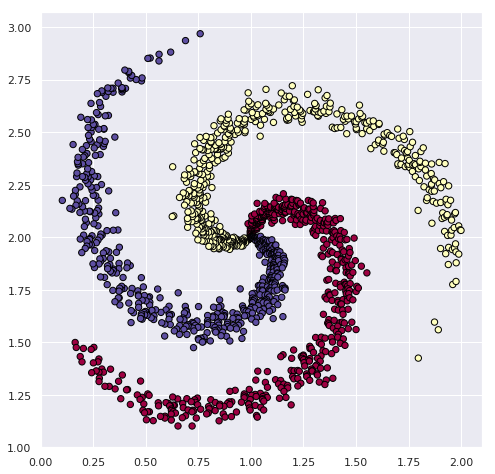

In [2]:
N = 500 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
seed = 4 #keep seed
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
np.random.seed(seed) #fixing random 
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
X[:, 0] += 1
X[:, 1] += 2
# lets visualize the data:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors="black")
ax = plt.gca()
ax.set_aspect("equal")
plt.show()

#### Split into train and test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

#### Some helpers

In [4]:
def plot(h=0.02):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))
    Z = sess.run(y_predicted, feed_dict={input_X: np.column_stack([xx.ravel(), yy.ravel()])})
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10,8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.gca().set_aspect("equal")
    plt.show()
    
    
def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

### For this task we gonna use tf.nn module 
#### more info: https://www.tensorflow.org/api_docs/python/tf/nn

#### Define input and targed placeholders

In [5]:
input_X = tf.placeholder(tf.float32, shape=[None, 2], 
                         name="X")
target_y = tf.placeholder(tf.int32, shape=[None], 
                          name="target_Y_integer")


#### Create Model

In [6]:
with tf.name_scope("Model"):
    
    l1 = tf.layers.dense(input_X, units=10, 
                         activation=tf.nn.sigmoid)

    l2 = tf.layers.dense(l1, units=3, activation=None)

    l_out = tf.nn.softmax(l2)

    y_predicted = tf.argmax(l_out, axis=-1)
    
with tf.name_scope("Loss"):
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target_y, logits=l2, name="softmax_loss"))

with tf.name_scope("Accuracy"):
    accuracy, update_accuracy = tf.metrics.accuracy(target_y, y_predicted)
    
with tf.name_scope("Optimizer"):
    optimzer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
    train_step = optimzer.minimize(loss)
    

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


#### Trainable variables

In [7]:
weights = tf.trainable_variables()
weights

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(10, 3) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(3,) dtype=float32_ref>]

### Train

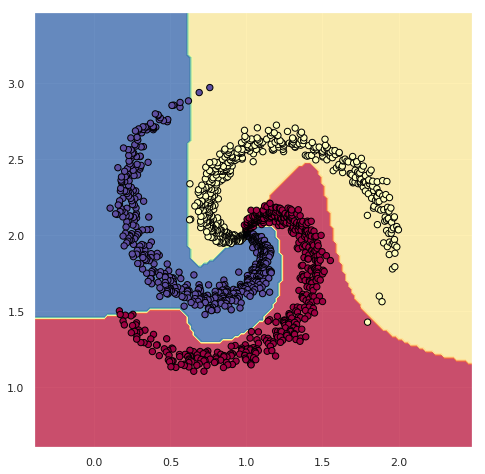

  training loss (in-iteration):		0.166523
  train accuracy:		95.36 %
  validation accuracy:		94.44 %


In [13]:
num_epochs = 1000
batch_size = 20

with tf.Session() as sess:
    # initialize global wariables
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0

        sess.run(tf.local_variables_initializer())
        for batch in iterate_minibatches(X_train, y_train,batch_size):
            inputs, targets = batch
            
            _, train_err_batch, _ = sess.run(
                [train_step, loss, update_accuracy], 
                feed_dict={input_X: inputs, target_y:targets}
            )
            train_err += train_err_batch
            train_batches += 1
            
        if epoch%2==0:
            plot()

            train_acc = sess.run(accuracy)

        # And a full pass over the validation data:
            sess.run(tf.local_variables_initializer())
            for batch in iterate_minibatches(X_test, y_test, batch_size):
                inputs, targets = batch
                sess.run(update_accuracy, feed_dict={input_X: inputs, 
                                                     target_y:targets})
            val_acc = sess.run(accuracy)


        
            print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))

            print("  train accuracy:\t\t{:.2f} %".format(
                train_acc * 100))

            print("  validation accuracy:\t\t{:.2f} %".format(
                val_acc * 100))
            clear_output(wait=True)

        save model
        save_path = saver.save(sess, model_path, global_step=epoch)
        print("  Model saved in file: %s" % save_path)

In [ ]:
tf.reset_default_graph()